# 2.1. Деревья решений. Классификация

### Agenda:
* критерий информативности
* визуализация разделяющих поверхностей решения и визуализация самого дерева
* оценка важности фичей
* ужасы переобучения

## 1. Критерий информативности

как мы разобрали, построение дерева зависит от следующих факторов:
* вид правила разбиения
* критерий информативности
* критерий останова
* метод стрижки
* проблема пропусков

пройдёмся критериям информативности

In [1]:
import numpy as np
from collections import Counter

*Нам понадобятся две библиотеки: numpy вы знаете, а объект класса Counter в заданном списке просто подсчитывает количество вхождений каждого элемента и возвращает результат в виде словаря. Пример:*

In [ ]:
Counter([9,9,9,7,7])

*Для численного измерения улучшения разбиений на каждом этапе мы вводим некоторый *критерий информативности*, который будет оценивать разнообразие объектов в выборке: чем больше разных классов в выборке, тем больше значение H(R). Чем меньше взвешенное значение критерия после разбиения - тем лучше*

Ниже представлена функция для расчёта энтропийного критерия качества:

$H(R) = -\sum_{k=1}^{K}p_klogp_k$

 ### **Задание.** Дополните функцию расчёта энтропийного критерия множества

In [2]:
import math

def HEntropy(l):
    length = len(l)
    cnt = Counter(l)
    
    HE = 0
    for c in cnt.values():
        HE -= c * math.log10(c / length) / length
    return HE

In [3]:
HEntropy([9,9,9,7,7])

0.29228525323862886

**Задание.** По аналогии с *энтропийным критерием* заполните функции *критерия Джини*

$Н(R) = -\sum_{k=1}^{K}p_k(1-p_k)$

In [4]:
def HGini(l):
    length = len(l)
    cnt = Counter(l)

    return sum([c * (1 - c / length) / length for c in cnt.values()])


In [5]:
HGini([9,9,9,7,7])

0.48000000000000004

###  Information Gain
*Information Gain (IG)* - функционал качества, отвечающий на вопрос, а сколько энтропии мы погасили при определённом разбиении? На каждом шаге разбиения при построении дерева максимизируется IG. Формула для вычисления при критерии информативности H:

$IG(R) = H(R) - \frac{|R_l|}{|R|}H(R_l) - \frac{|R_r|}{|R|}H(R_r)$

### **Задание.** Заполните функцию для вычисления функционала качества

In [6]:
def IG(H, l, i):
    ln = len(l)
    return H(l) - (i / ln) * H(l[:i]) - (ln - i) * H(l[i:]) / ln


### Тут функция для визуализации работы произвольного критерия качества на выборке

In [7]:
def test_H(H, l):
    print("{:5} {:3}   {:4} {:4} {:4}".format("#","l","IG","Hl","Hr"))
    print("-"*24)
    for i in range(1,len(l)):
        print("{:2}. {:3}   {:.2f} {:.2f} {:.2f}".format(i, l[i], IG(H, l, i), H(l[:i]), H(l[i:])))

Определим как-нибудь выборку и посмотрим, какое разбиение предложат критерии информативности. Замечу, что элементы здесь будут выводиться начиная со второго, а значения функций рассчитаны для разбиения *перед* элементом строки

In [8]:
l = [1]*5 + [2]*3 + [1]*4
print(l)

[1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1]


In [9]:
test_H(HEntropy, l)

#     l     IG   Hl   Hr  
------------------------
 1.   1   0.01 0.00 0.25
 2.   1   0.02 0.00 0.27
 3.   1   0.04 0.00 0.28
 4.   1   0.05 0.00 0.29
 5.   2   0.07 0.00 0.30
 6.   2   0.01 0.20 0.28
 7.   2   0.00 0.26 0.22
 8.   1   0.05 0.29 0.00
 9.   1   0.04 0.28 0.00
10.   1   0.02 0.27 0.00
11.   1   0.01 0.25 0.00


In [10]:
test_H(HGini, l)

#     l     IG   Hl   Hr  
------------------------
 1.   1   0.01 0.00 0.40
 2.   1   0.02 0.00 0.42
 3.   1   0.04 0.00 0.44
 4.   1   0.06 0.00 0.47
 5.   2   0.09 0.00 0.49
 6.   2   0.01 0.28 0.44
 7.   2   0.00 0.41 0.32
 8.   1   0.06 0.47 0.00
 9.   1   0.04 0.44 0.00
10.   1   0.02 0.42 0.00
11.   1   0.01 0.40 0.00


## 2. Визуализация принятия решений классификатором sklearn

#### 1. Используем данные о цветках ириса из занятия

In [11]:
from sklearn.datasets import load_boston
import pandas as pd

In [12]:
from matplotlib import pyplot as plt
# %matplotlib inline
import seaborn as sns

In [13]:
boston = load_boston()

In [14]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [15]:
dir(boston)

['DESCR', 'data', 'feature_names', 'filename', 'target']

In [16]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['med_price'])
df = pd.concat([X,y], axis=1)

In [17]:
print(df.shape)
df.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,med_price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CRIM       506 non-null    float64
 1   ZN         506 non-null    float64
 2   INDUS      506 non-null    float64
 3   CHAS       506 non-null    float64
 4   NOX        506 non-null    float64
 5   RM         506 non-null    float64
 6   AGE        506 non-null    float64
 7   DIS        506 non-null    float64
 8   RAD        506 non-null    float64
 9   TAX        506 non-null    float64
 10  PTRATIO    506 non-null    float64
 11  B          506 non-null    float64
 12  LSTAT      506 non-null    float64
 13  med_price  506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [19]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,med_price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [20]:
df['med_price'].unique()

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 13.6, 19.6, 15.2, 14.5,
       15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 13.2, 13.1, 13.5, 20. ,
       24.7, 30.8, 34.9, 26.6, 25.3, 21.2, 19.3, 14.4, 19.4, 19.7, 20.5,
       25. , 23.4, 35.4, 31.6, 23.3, 18.7, 16. , 22.2, 33. , 23.5, 22. ,
       17.4, 20.9, 24.2, 22.8, 24.1, 21.4, 20.8, 20.3, 28. , 23.9, 24.8,
       22.5, 23.6, 22.6, 20.6, 28.4, 38.7, 43.8, 33.2, 27.5, 26.5, 18.6,
       20.1, 19.5, 19.8, 18.8, 18.5, 18.3, 19.2, 17.3, 15.7, 16.2, 18. ,
       14.3, 23. , 18.1, 17.1, 13.3, 17.8, 14. , 13.4, 11.8, 13.8, 14.6,
       15.4, 21.5, 15.3, 17. , 41.3, 24.3, 27. , 50. , 22.7, 23.8, 22.3,
       19.1, 29.4, 23.2, 24.6, 29.9, 37.2, 39.8, 37.9, 32.5, 26.4, 29.6,
       32. , 29.8, 37. , 30.5, 36.4, 31.1, 29.1, 33.3, 30.3, 34.6, 32.9,
       42.3, 48.5, 24.4, 22.4, 28.1, 23.7, 26.7, 30.1, 44.8, 37.6, 46.7,
       31.5, 31.7, 41.7, 48.3, 29. , 25.1, 17.6, 24

#### 2. Используем регрессор

In [22]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# DecisionTreeClassifier?

In [23]:
clf = DecisionTreeRegressor()

In [24]:
clf.fit(X, y)

DecisionTreeRegressor()

In [25]:
clf.feature_importances_

array([4.77373786e-02, 5.51035341e-04, 2.20331963e-03, 1.02203204e-03,
       5.01904375e-02, 5.76687713e-01, 1.34963248e-02, 7.24050338e-02,
       3.16481486e-04, 1.39757432e-02, 2.00908231e-02, 6.32365011e-03,
       1.95000027e-01])

Отобразим наглядно важность фич

''

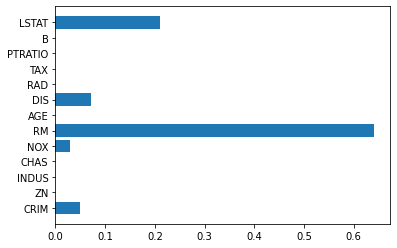

In [42]:
plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(X.columns)),X.columns)
''

Видно, что в данном прогоне по дереву важными получились фичи RM и LSTAT

In [26]:
# Xcut = X[['NOX', 'LSTAT']]
Xcut = X[['RM', 'LSTAT']]

Визуализируем границу принятия решений. Для удобства все упаковано в функцию **test_clf**, в неё передаётся созданный классификатор и при установленном fit_clf=True обучается внутри, а затем отрисовывает границу. Таким образом можно экспериментировать с параметрами классификатора

In [27]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [28]:
def test_clf(clf, X, y,cy=0, fit_clf=False):
    xx, yy = get_grid(X.values)
    if fit_clf:
        clf.fit(X, y)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, predicted, cmap='Pastel1',shading='auto')
    plt.scatter(X.values[:, 0], X.values[:, 1], s=100, cmap='tab10',c=cy)
    if fit_clf:
        return clf

*попробуйте при разной глубине*

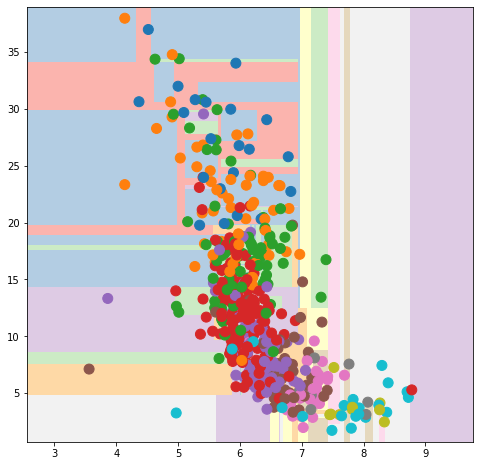

In [33]:
clf = test_clf(DecisionTreeRegressor(max_depth=10), Xcut, y,cy=y['med_price'].tolist(), fit_clf=True)

обратите внимание, один блок занимает то позицию снизу, то слева: данных недостаточно для принятия однозначного решения и экстраполяция идёт произвольно

#### 3. Визуализируем само дерево

Возможно, самое замечательное свойство одиночных деревьев - возможность визуализировать их алгоритм работы и затем объяснить его хоть человеку, хоть машине

Дерево можно как-то отобразить внутри ipython-ноутбука с помощью библиотеки pydot и установлнного webgraphviz, но мы воспользуемся скорее онлайн-сервисом http://www.webgraphviz.com

Сгенерируем код дерева в формате .dot и скопируем его на сайт

In [34]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [44]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

def get_tree_view(clf):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

Дерево нарисуем для глубины 3, иначе слишком мелкая картинка получается с графом

In [56]:
clf = DecisionTreeRegressor(max_depth=3)
clf.fit(Xcut, y)

DecisionTreeRegressor(max_depth=3)

In [57]:
get_tree_dot_view(clf, list(Xcut.columns), boston.target)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="RM <= 6.941\nmse = 84.42\nsamples = 506\nvalue = 22.533", fillcolor="#f7d9c3"] ;
1 [label="LSTAT <= 14.4\nmse = 40.273\nsamples = 430\nvalue = 19.934", fillcolor="#f9e3d2"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="LSTAT <= 4.91\nmse = 26.009\nsamples = 255\nvalue = 23.35", fillcolor="#f6d6be"] ;
1 -> 2 ;
3 [label="mse = 47.187\nsamples = 20\nvalue = 31.565", fillcolor="#f0b78e"] ;
2 -> 3 ;
4 [label="mse = 17.974\nsamples = 235\nvalue = 22.651", fillcolor="#f7d8c2"] ;
2 -> 4 ;
5 [label="LSTAT <= 19.83\nmse = 19.276\nsamples = 175\nvalue = 14.956", fillcolor="#fdf5f0"] ;
1 -> 5 ;
6 [label="mse = 12.575\nsamples = 99\nvalue = 16.954", fillcolor="#fbeee4"] ;
5 -> 6 ;
7 [label="mse = 16.036\nsamples = 76\nvalue = 12.354", fillcolor="#ffffff"] ;
5 -> 7 ;
8 [label="RM <= 7.437\nmse = 79.729\nsamples = 76\nvalue = 37.238", fillcolor="#eca26c"] ;
0 -> 8 [labeldistance=2.5, labelangle=-45,

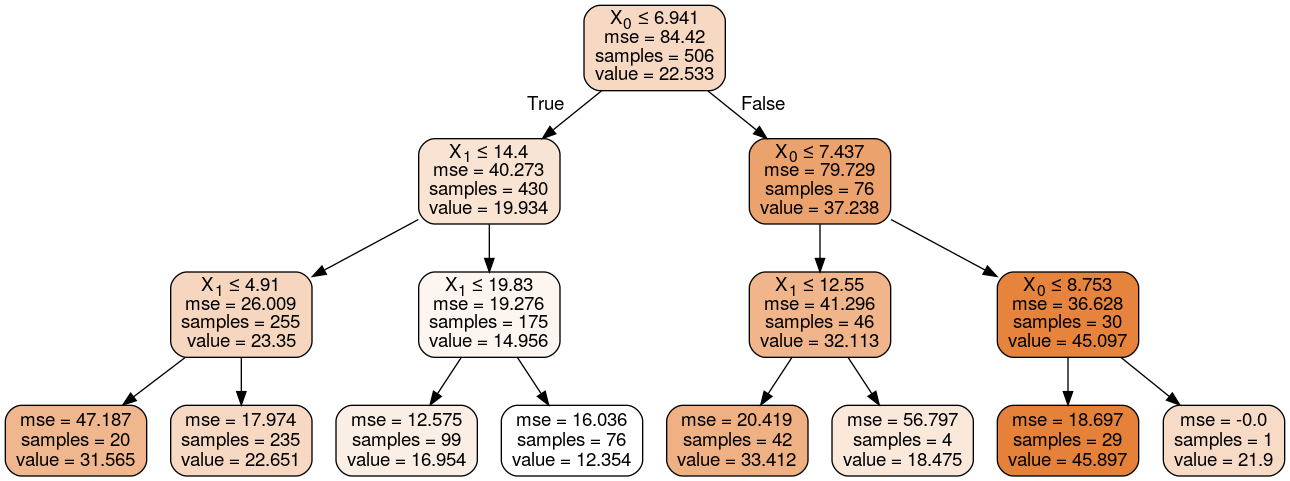

In [58]:
get_tree_view(clf)

-----

**Задание**
1. визуализировать дерево
2. вставить скрин с картинкой сюда в ipython notebook (!\[text](imagename.png))
3. проверить индексы Джини в узлах: совпадают с нашей расчётной функцией?
4. ветка налево - это True или False? что значит цвет узла? class? values?

-----

## 3. Оценка важности фичей

важность зависит от конкретного прогона классификатора, это не объективный показатель, но дающий представление

*попробуйте при разной глубине*

''

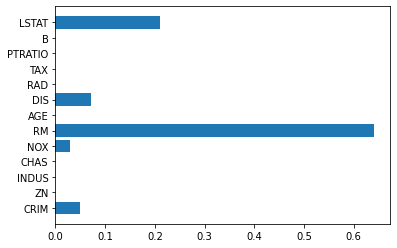

In [41]:
clf = DecisionTreeRegressor(max_depth=3)
clf.fit(X, y)

plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(X.columns)),X.columns)
''

## 4. Переообучение наглядно

*здесь я использую генерацию датасета из [блога](https://habrahabr.ru/company/ods/blog/322534/) open data science*

In [ ]:
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]
train_data = pd.DataFrame(train_data)

In [ ]:
plt.scatter(train_data[0], train_data[1], c=train_labels, s=100, cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

*попробуйте при разной глубине*

In [ ]:
train_labels

In [ ]:
plt.scatter(train_data.values[:, 0], train_data.values[:, 1], s=100, cmap='tab10',c=y['species'].tolist())

In [ ]:
clf = test_clf(DecisionTreeClassifier(max_depth=1), train_data, train_labels,cy=train_labels, fit_clf=True)

In [ ]:
clf = test_clf(DecisionTreeClassifier(), train_data, train_labels,cy=train_labels, fit_clf=True)

А здесь можно увидеть огромное переобученное дерево: http://www.webgraphviz.com

In [ ]:
clf = test_clf(DecisionTreeClassifier(max_depth=2), train_data, train_labels,cy=train_labels, fit_clf=True)

In [ ]:
clf = test_clf(DecisionTreeClassifier(max_depth=10), train_data, train_labels,cy=train_labels, fit_clf=True)
get_tree_dot_view(clf, feature_names=['x','y'])